### Trying to make glass distributions to improve computation time

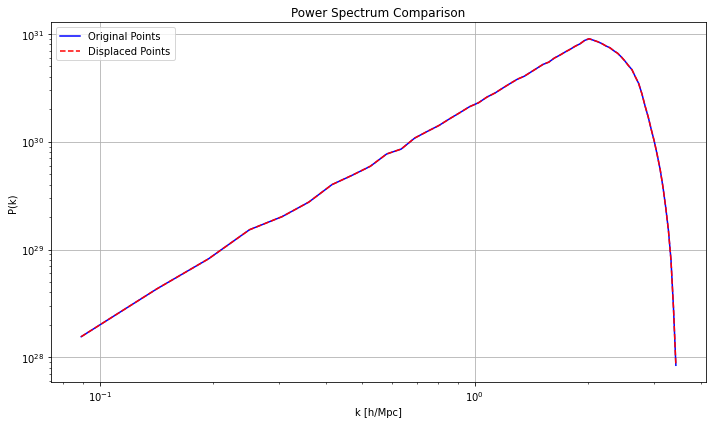

In [20]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftfreq
from scipy.interpolate import RegularGridInterpolator
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import matplotlib.pyplot as plt

def compute_zeldovich_displacements(grid_size, box_size, power_spectrum, redshift):
    # (Same as before)
    D_growth = cosmo.scale_factor(redshift)
    k = fftfreq(grid_size, d=box_size / grid_size) * 2 * np.pi
    kx, ky, kz = np.meshgrid(k, k, k, indexing="ij")
    k2 = kx**2 + ky**2 + kz**2
    k2[k2 == 0] = 1e-10
    delta_k = (np.random.normal(0, 1, (grid_size, grid_size, grid_size)) +
               1j * np.random.normal(0, 1, (grid_size, grid_size, grid_size)))
    delta_k *= np.sqrt(power_spectrum(np.sqrt(k2)))
    displacement_x_k = -1j * kx * delta_k / k2
    displacement_y_k = -1j * ky * delta_k / k2
    displacement_z_k = -1j * kz * delta_k / k2
    displacement_x = np.real(ifftn(displacement_x_k)) * D_growth
    displacement_y = np.real(ifftn(displacement_y_k)) * D_growth
    displacement_z = np.real(ifftn(displacement_z_k)) * D_growth
    displacements = np.stack([displacement_x, displacement_y, displacement_z], axis=0)
    return displacements

def apply_displacements_to_points(points, displacements, box_size):
    # (Same as before)
    grid_size = displacements.shape[1]
    grid_coords = np.linspace(0, box_size, grid_size)
    interpolators = [
        RegularGridInterpolator((grid_coords, grid_coords, grid_coords), displacements[i], bounds_error=False, fill_value=0)
        for i in range(3)
    ]
    interpolated_displacements = np.stack([interp(points) for interp in interpolators], axis=-1)
    displaced_points = points + interpolated_displacements
    return displaced_points

def calculate_power_spectrum(points, box_size, grid_size):
    """
    Calculate the power spectrum of a set of points.

    Parameters:
        points (ndarray): Array of points (N, 3).
        box_size (float): Size of the box in Mpc/h.
        grid_size (int): Number of grid cells along one dimension.

    Returns:
        k (ndarray): Wavenumbers.
        Pk (ndarray): Power spectrum values.
    """
    # Create a 3D density grid
    density_grid, _ = np.histogramdd(points, bins=grid_size, range=[[0, box_size]]*3)
    density_grid -= np.mean(density_grid)  # Subtract mean density
    density_grid /= (np.mean(density_grid)+1e-10)  # Divide by mean density

    # Fourier transform of the density field
    delta_k = fftn(density_grid)
    power_spectrum = np.abs(delta_k)**2

    # Compute k bins and average power spectrum
    grid = fftfreq(grid_size, box_size / grid_size) * 2 * np.pi
    kx, ky, kz = np.meshgrid(grid, grid, grid, indexing='ij')
    k = np.sqrt(kx**2 + ky**2 + kz**2).flatten()
    power_spectrum = power_spectrum.flatten()

    k_bins = np.linspace(0, np.max(k), grid_size // 2)
    Pk, _ = np.histogram(k, bins=k_bins, weights=power_spectrum)
    k_avg, _ = np.histogram(k, bins=k_bins, weights=k)

    k_avg = k_avg / np.maximum(np.histogram(k, bins=k_bins)[0], 1) #avoid division by zero
    return k_avg[1:], Pk[1:]  # Exclude the first bin (k=0)

# Parameters
grid_size = 128
box_size = 200.0  # Mpc/h
redshift = 0.5
num_points = 1000000

# Power spectrum function
def example_power_spectrum(k):
    return np.where(k > 0, k**-2, 0)

# Generate random points
random_points = np.random.uniform(0, box_size, (num_points, 3))

# Compute Zel'dovich displacements and apply them
displacements = compute_zeldovich_displacements(grid_size, box_size, example_power_spectrum, redshift)
displaced_points = apply_displacements_to_points(random_points, displacements, box_size)

# Calculate power spectra
k_original, Pk_original = calculate_power_spectrum(random_points, box_size, grid_size)
k_displaced, Pk_displaced = calculate_power_spectrum(displaced_points, box_size, grid_size)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.loglog(k_original, Pk_original, label='Original Points', color='blue')
plt.loglog(k_displaced, Pk_displaced, label='Displaced Points', color='red', linestyle='--')

n_mean = num_points / box_size**3
P_shot = 1 / n_mean
#plt.axhline(P_shot, color='gray', linestyle='--', label='Shot Noise')
#plt.axvline(2, color='gray', linestyle='-')

plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from astropy.cosmology import Planck